# Imports

In [1]:
# %% Imports y configuración
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Agregar el directorio raíz al path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

from model_dpm.simulations.sim_mixture import multimodal_mixture_sampler
from model_dpm.utils.sistem_fun import load_config, get_data_path, get_report_path
from model_dpm.models.kernel_laplace_v1 import DPMLaplace
from model_dpm.models.kernel_normal_v2 import DPMNormal
from model_dpm.graphics.density import plot_density_estimation
from model_dpm.graphics.diagnostic import plot_cluster_assignment, plot_cluster_densities, plot_traces
from model_dpm.graphics.app_1 import plot_density_credible_interval
from model_dpm.utils.sistem_regist import register_experiment
from model_dpm.utils.sistem_artefact import save_artifact

config=load_config()

# Lectura de data 

In [2]:
from pathlib import Path

# Encontrar la raíz del proyecto
current_dir = Path.cwd()
print(f" Directorio actual: {current_dir}")

# Buscar el archivo
project_root = current_dir
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

csv_path = project_root / "data" / "reales" / "employee_salary_dataset.csv"  # MODIFICAR ESTO 


if csv_path.exists():
    datos = pd.read_csv(csv_path)
    print(f"\n✅ Datos cargados: {len(datos)} filas")
    print(datos.head())
else:
    print("\n❌ Archivo no encontrado")
    print(f"Archivos disponibles en {csv_path.parent}:")
    if csv_path.parent.exists():
        for f in csv_path.parent.glob("*.csv"):
            print(f"  • {f.name}")

 Directorio actual: c:\Users\JuanFran\Desktop\git_tesis\model_dpm\notebooks\reales

✅ Datos cargados: 50 filas
   EmployeeID        Name  Department  Experience_Years Education_Level  Age  \
0           1  Employee_1   Marketing                15          Master   53   
1           2  Employee_2  Operations                 7        Bachelor   25   
2           3  Employee_3          IT                12     High School   51   
3           4  Employee_4  Operations                 8             PhD   44   
4           5  Employee_5  Operations                15          Master   36   

   Gender       City  Monthly_Salary  
0  Female      Delhi          111416  
1  Female  Bangalore           95271  
2  Female  Hyderabad           69064  
3    Male      Delhi           95091  
4  Female      Delhi          132450  


## Configuracion para Kernel Normal

In [3]:
# %% Parámetros de ejecución
NOMBRE_EJECUCION = "employe_dataset_001"
SIM_REAL = "real"
CARACTERISTICAS = "Salarios de empleados"

print(f"📊 Ejecución: {NOMBRE_EJECUCION}")
print(f"📁 Tipo: {SIM_REAL}")
print(f"📝 Notas: {CARACTERISTICAS}")

# Registrar experimento
experiment_id = register_experiment(
    config=config,
    run_name=NOMBRE_EJECUCION,
    experiment_type=SIM_REAL,
    description=CARACTERISTICAS
)

# Persistir ID del experimento en la configuración en memoria
config["current_experiment"]["id"] = experiment_id
config["current_experiment"]["type"] = SIM_REAL
config["current_experiment"]["description"] = CARACTERISTICAS

📊 Ejecución: employe_dataset_001
📁 Tipo: real
📝 Notas: Salarios de empleados
✅ Experimento registrado: v2.0.0_employe_dataset_001_20251223_011704
📁 Registry: C:\Users\JuanFran\Desktop\git_tesis\model_dpm\model_dpm\..\versioning\experiment_registry.md


### DPM Normal

In [4]:
##################################################
# Aplicar la clase del modelo
##################################################

# %% Inicializar y ajustar modelo
print("\n🔧 Inicializando modelo DPM con kernel normal...")

# Crear instancia del modelo
model = DPMNormal(
    y=datos['Monthly_Salary'].values,
    H=20,                             # Truncamiento inicial
    M_prior=(2.0, 1.0),               # Prior para concentración
    mu0_prior=(0.0, 10.0),            # Prior para μ₀
    kappa0_prior=(1.0, 1.0),          # Prior para κ₀
    a0_prior=(2.0, 1.0),              # Prior para a₀
    b0_prior=(2.0, 1.0),              # Prior para b₀
    verbose=True
)

# Ajustar el modelo
print("🔄 Ajustando modelo con Slice Sampling ...")
trace = model.run(iterations=2000, burnin=500)

print("✅ Modelo ajustado exitosamente")

##################################################
# Guardar clase
##################################################

# Guardar trace
trace_path = save_artifact(
    config=config,
    experiment_id=experiment_id,
    artifact=trace,
    artifact_name="trace",
    data_type=SIM_REAL
)

# Guardar modelo completo
model_path = save_artifact(
    config=config,
    experiment_id=experiment_id,
    artifact=model,
    artifact_name="model",
    data_type=SIM_REAL
)

print("✅ Modelo Guardado exitosamente")


🔧 Inicializando modelo DPM con kernel normal...
🔄 Ajustando modelo con Slice Sampling ...
Iter 100/2000: K_eff=8, M=1.60, μ₀=-0.70, κ₀=0.13, a₀=3.16, b₀=0.73 [Acc: κ=0.81, a=0.76]
Iter 200/2000: K_eff=5, M=1.60, μ₀=-0.39, κ₀=0.01, a₀=2.60, b₀=0.21 [Acc: κ=0.95, a=0.72]
Iter 300/2000: K_eff=3, M=1.07, μ₀=-3.33, κ₀=0.01, a₀=1.13, b₀=0.58 [Acc: κ=0.86, a=0.62]
Iter 400/2000: K_eff=2, M=0.53, μ₀=-0.27, κ₀=0.04, a₀=1.70, b₀=0.65 [Acc: κ=0.93, a=0.58]
Iter 500/2000: K_eff=3, M=0.46, μ₀=-5.49, κ₀=0.01, a₀=1.61, b₀=0.89 [Acc: κ=0.84, a=0.55]
Iter 600/2000: K_eff=1, M=0.10, μ₀=-3.94, κ₀=0.01, a₀=3.96, b₀=2.45 [Acc: κ=0.90, a=0.62]
Iter 700/2000: K_eff=1, M=0.26, μ₀=0.08, κ₀=0.01, a₀=2.26, b₀=1.26 [Acc: κ=0.93, a=0.64]
Iter 800/2000: K_eff=2, M=0.31, μ₀=2.73, κ₀=0.04, a₀=2.06, b₀=2.57 [Acc: κ=0.91, a=0.56]
Iter 900/2000: K_eff=1, M=0.54, μ₀=-2.82, κ₀=0.10, a₀=2.57, b₀=2.01 [Acc: κ=0.87, a=0.58]
Iter 1000/2000: K_eff=2, M=0.16, μ₀=2.39, κ₀=0.01, a₀=3.76, b₀=3.48 [Acc: κ=0.92, a=0.57]
Iter 1100/2

### Graficas y analisis 

In [5]:
##################################################
# Resultados exploratorios
##################################################

# Ultima asignación de la cadena
cluster_assignments = trace['z'][-1]

# Agregar al dataframe
datos['cluster'] = cluster_assignments

# Número de clusters efectivos
n_clusters = len(np.unique(cluster_assignments))
print(f"📈 Número de clusters encontrados: {n_clusters}")

print("\n📊 Distribución de observaciones por cluster:")
print(datos['cluster'].value_counts().sort_index())

# %% Estadísticas por cluster
print("\n📈 Estadísticas por cluster:")
cluster_stats = datos.groupby('cluster')['Monthly_Salary'].agg(['mean', 'std', 'count'])
print(cluster_stats)

📈 Número de clusters encontrados: 3

📊 Distribución de observaciones por cluster:
cluster
0    23
1    26
3     1
Name: count, dtype: int64

📈 Estadísticas por cluster:
                  mean           std  count
cluster                                    
0        108883.608696  23107.499540     23
1         57006.576923  18267.501226     26
3        127946.000000           NaN      1



📊 Generando gráfico de densidad...


📊 Generando gráfico de asignación de clusters...
📊 Generando gráfico de densidades por cluster...
📊 Generando gráficos de trazas...


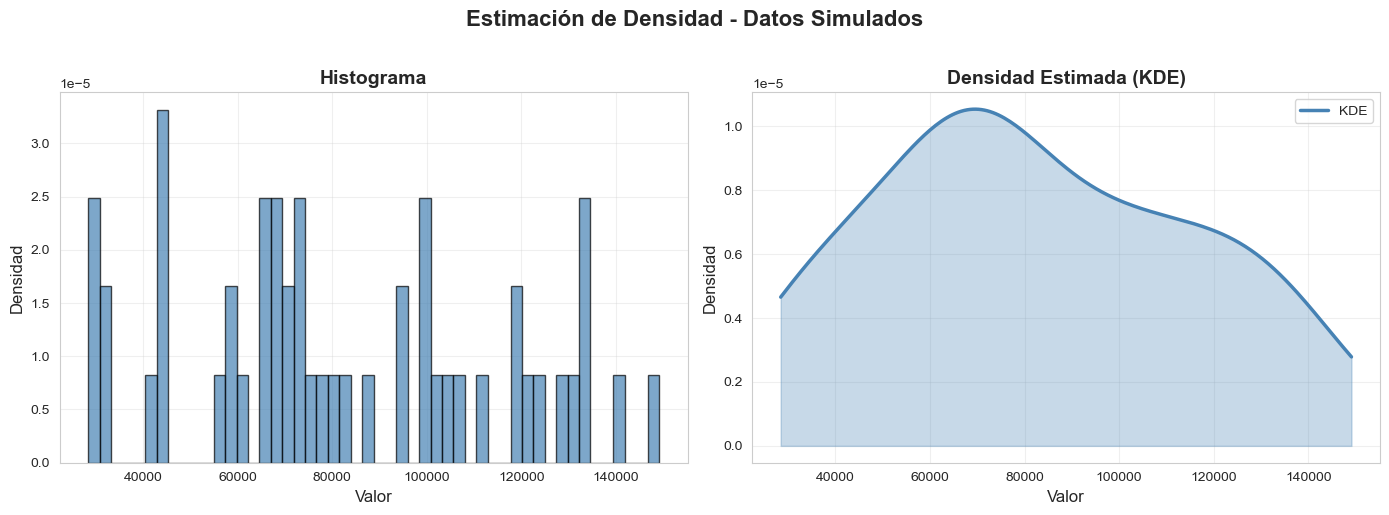

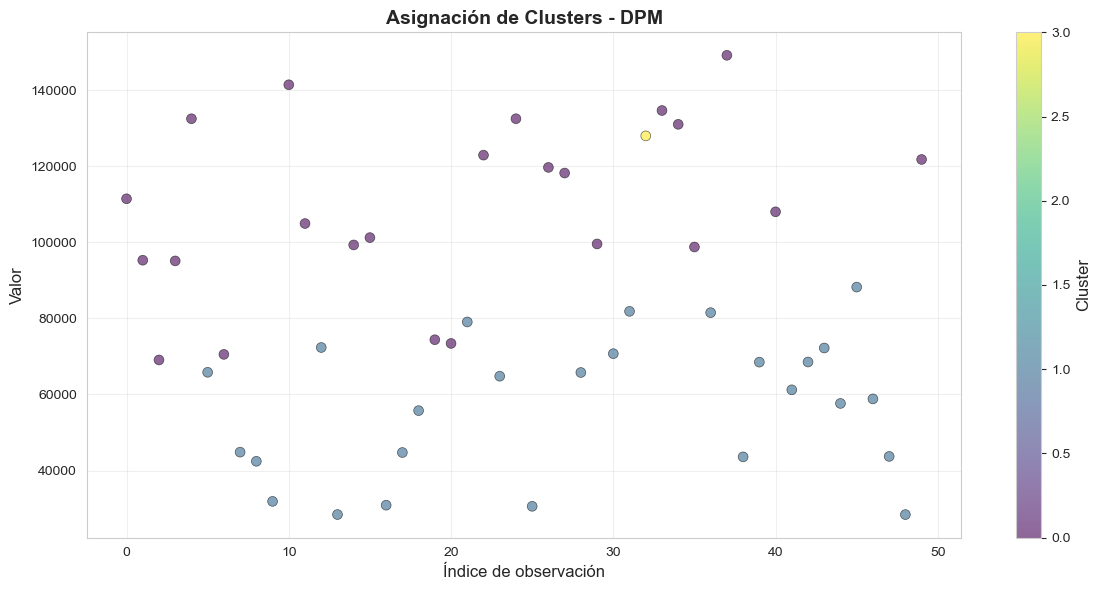

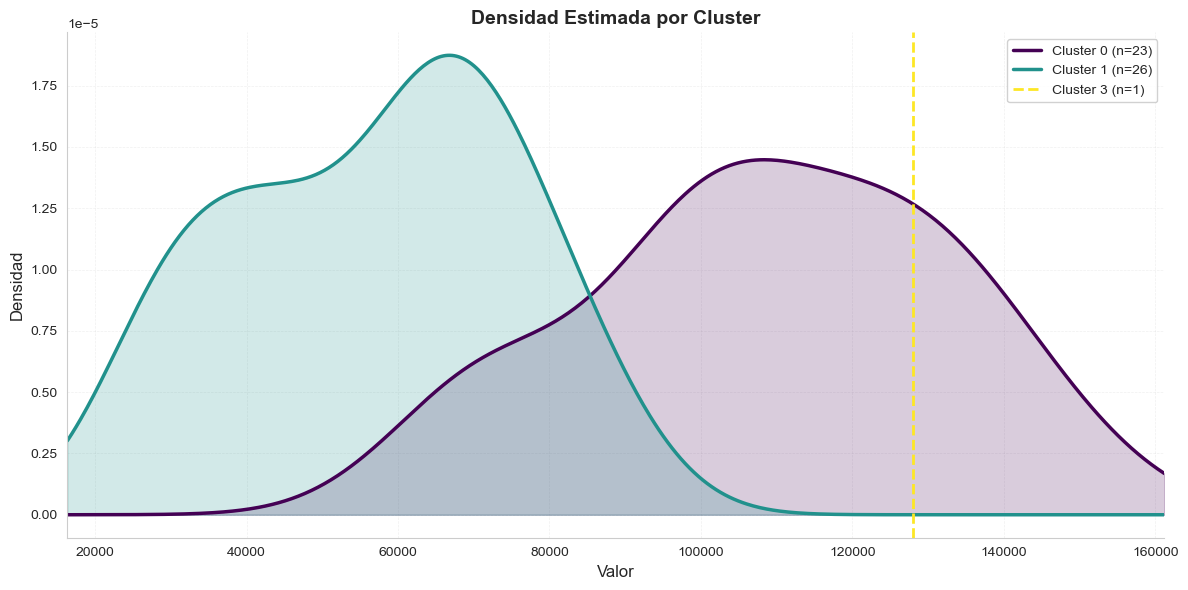

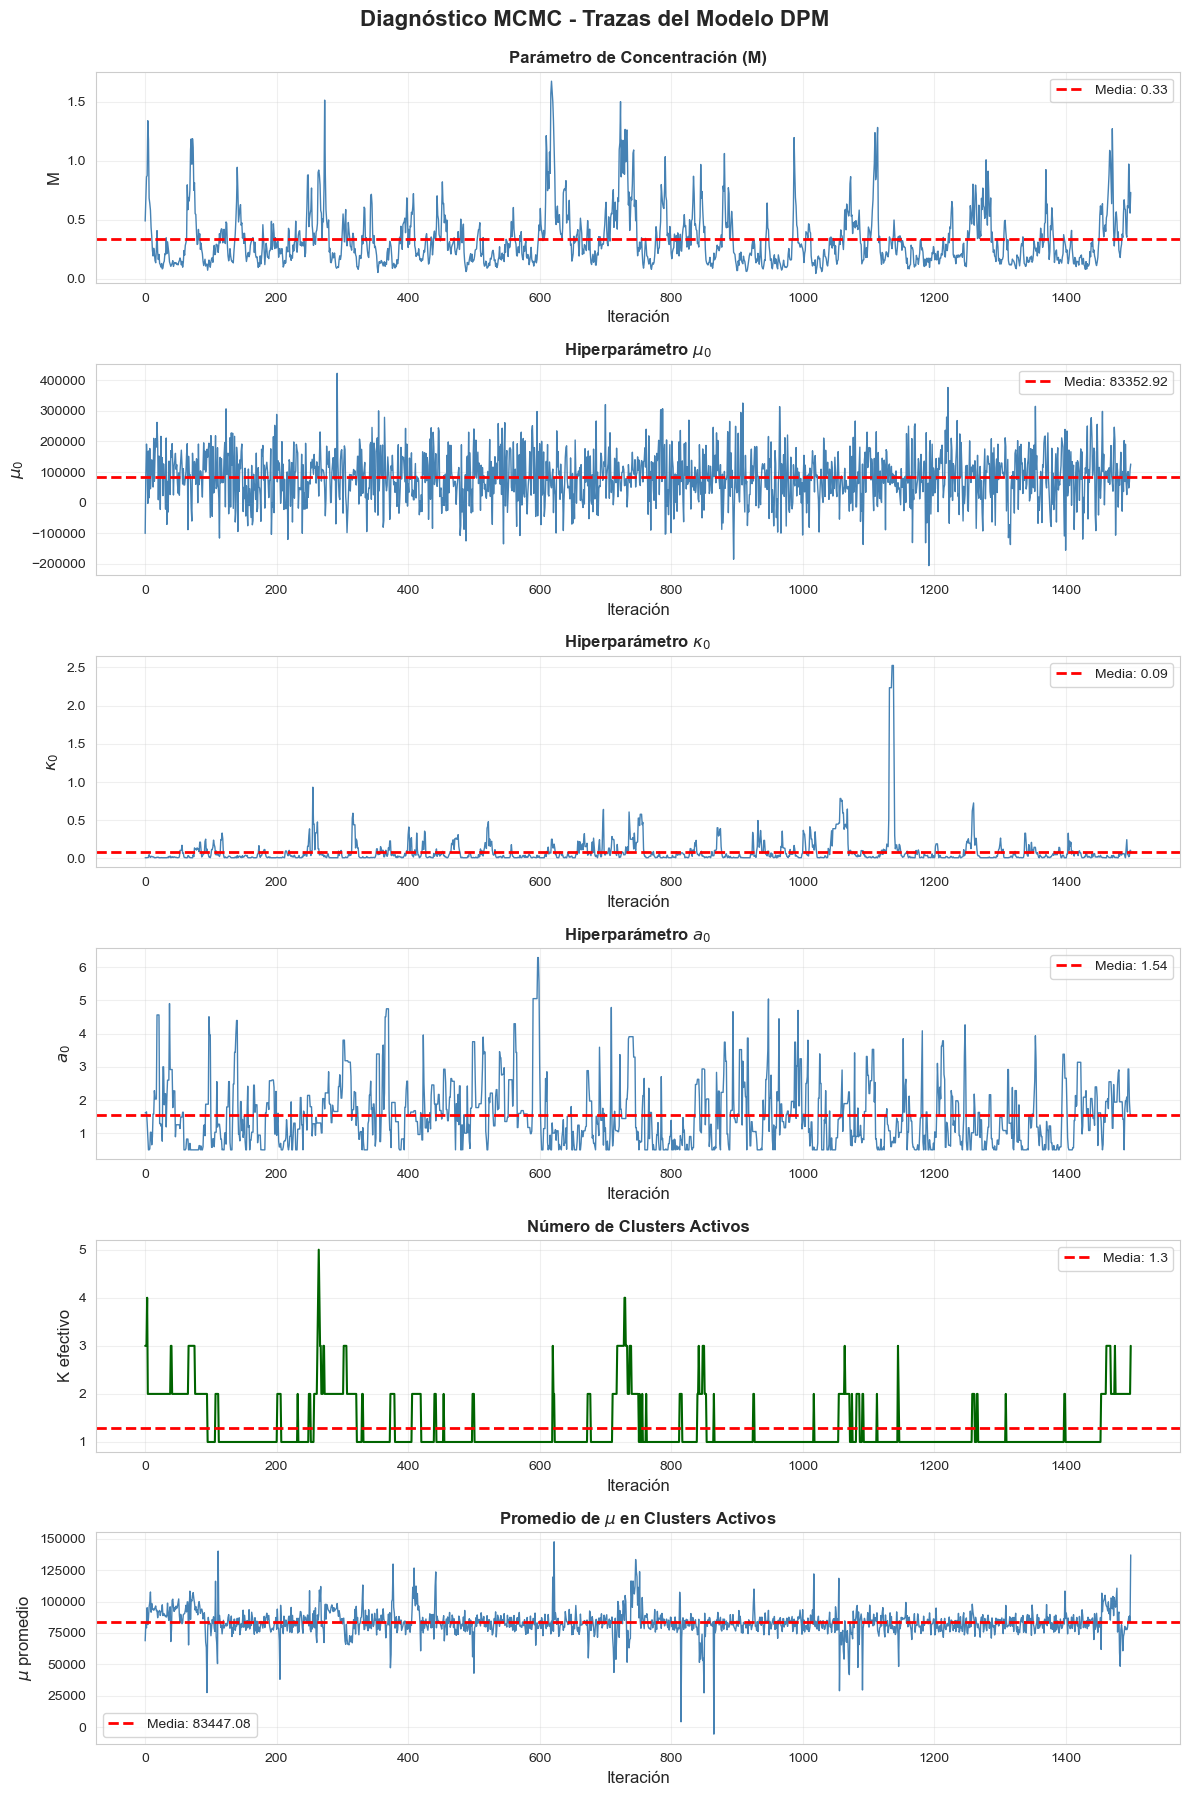

In [6]:
##################################################
# Graficos de diagnostico y analisis
##################################################

# %% 1. Gráfico de Densidad Estimada (Histograma + KDE)
print("\n📊 Generando gráfico de densidad...")
graphics_base_path = get_report_path(config, data_type=SIM_REAL, report_type="graphics")
graphics_path = graphics_base_path / NOMBRE_EJECUCION  # Subcarpeta con nombre de ejecución
graphics_path.mkdir(parents=True, exist_ok=True)

fig1 = plot_density_estimation(
    data=datos['Monthly_Salary'].values,
    bins=50,
    title="Estimación de Densidad - Datos Simulados",
    save_path=graphics_path / "density.png"
)

# %% 2. Gráfico de Asignación de Clusters
print("📊 Generando gráfico de asignación de clusters...")
fig2 = plot_cluster_assignment(
    data=datos['Monthly_Salary'].values,
    clusters=datos['cluster'].values,
    title="Asignación de Clusters - DPM",
    save_path=graphics_path / "clusters_assignment.png"
)

# %% 3. Gráfico de Densidades por Cluster
print("📊 Generando gráfico de densidades por cluster...")
fig3 = plot_cluster_densities(
    data=datos['Monthly_Salary'].values,
    clusters=datos['cluster'].values,
    title="Densidad Estimada por Cluster",
    save_path=graphics_path / "clusters_densities.png"
)

# %% 4. Gráfico de Trazas (Diagnóstico MCMC)
print("📊 Generando gráficos de trazas...")
fig4 = plot_traces(
    trace=trace,
    burn_in=0,  # Ya aplicamos burnin en el modelo
    title="Diagnóstico MCMC - Trazas del Modelo DPM",
    save_path=graphics_path / "traces.png"
)

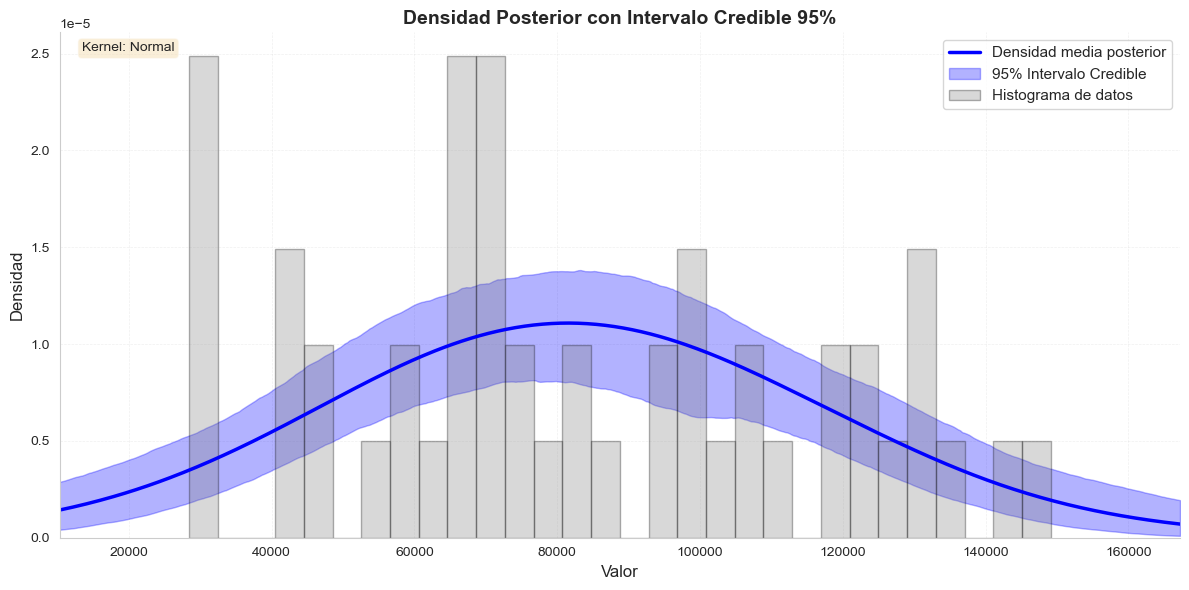

In [7]:
##################################################
# Graficos de intervalo de credibilidad 
##################################################
fig5 = plot_density_credible_interval(
    trace=trace,
    y_data=datos['Monthly_Salary'].values,
    kernel='normal',
    burn_in=0,  # Ya aplicamos burnin
    n_posterior=2000,
    title="Densidad Posterior con Intervalo Credible 95%",
    save_path=graphics_path / "credible_interval.png"
)

## Configuracion para kernel Laplace

In [8]:
# %% Parámetros de ejecución
NOMBRE_EJECUCION = "employe_dataset_002"
SIM_REAL = "real"
CARACTERISTICAS = "Salarios de empleados"

print(f"📊 Ejecución: {NOMBRE_EJECUCION}")
print(f"📁 Tipo: {SIM_REAL}")
print(f"📝 Notas: {CARACTERISTICAS}")

# Registrar experimento
experiment_id = register_experiment(
    config=config,
    run_name=NOMBRE_EJECUCION,
    experiment_type=SIM_REAL,
    description=CARACTERISTICAS
)

# Persistir ID del experimento en la configuración en memoria
config["current_experiment"]["id"] = experiment_id
config["current_experiment"]["type"] = SIM_REAL
config["current_experiment"]["description"] = CARACTERISTICAS

📊 Ejecución: employe_dataset_002
📁 Tipo: real
📝 Notas: Salarios de empleados
✅ Experimento registrado: v2.0.0_employe_dataset_002_20251223_012341
📁 Registry: C:\Users\JuanFran\Desktop\git_tesis\model_dpm\model_dpm\..\versioning\experiment_registry.md


### DPM Laplace

In [9]:
##################################################
# Aplicar la clase del modelo
##################################################
# Inicializar 
print("\n🔧 Inicializando modelo DPM con kernel Laplace...")

# Crear instancia del modelo Laplace
model_laplace = DPMLaplace(
    y=datos['Monthly_Salary'].values,
    H=20,                              # Truncamiento inicial
    M_prior=(2.0, 1.0),                # Prior para concentración M
    mu0_prior=(0.0, 100.0),            # Prior para μ₀
    kappa0_prior=(2.0, 1.0),           # Prior para κ₀
    a0_prior=(3.0, 1.0),               # Prior para a₀
    beta0_prior=(2.0, 1.0),            # Prior para β₀
    verbose=True
)

# Ajustar el modelo
print("🔄 Ajustando modelo Laplace con Slice Sampling...")
trace = model_laplace.run(iterations=2000, burnin=500)

print("✅ Modelo Laplace ajustado exitosamente\n")

##################################################
# Guardar clase
##################################################

# Guardar trace
trace_path = save_artifact(
    config=config,
    experiment_id=experiment_id,
    artifact=trace,
    artifact_name="trace",
    data_type=SIM_REAL
)

# Guardar modelo completo
model_path = save_artifact(
    config=config,
    experiment_id=experiment_id,
    artifact=model_laplace,
    artifact_name="model",
    data_type=SIM_REAL
)

print("✅ Modelo Guardado exitosamente")



🔧 Inicializando modelo DPM con kernel Laplace...
🔄 Ajustando modelo Laplace con Slice Sampling...
Iter 100/2000: K_eff=3, M=0.15, μ₀=-1.19, κ₀=0.24, a₀=1.27, β₀=1.98
  [Acc: μ=0.43, b=0.74, κ=0.88, a=0.88]
Iter 200/2000: K_eff=3, M=0.56, μ₀=-5.72, κ₀=0.01, a₀=1.22, β₀=2.62
  [Acc: μ=0.26, b=0.71, κ=0.83, a=0.79]
Iter 300/2000: K_eff=3, M=0.21, μ₀=0.62, κ₀=0.01, a₀=0.51, β₀=2.15
  [Acc: μ=0.18, b=0.50, κ=0.89, a=0.80]
Iter 400/2000: K_eff=4, M=0.71, μ₀=-1.43, κ₀=0.01, a₀=0.91, β₀=3.88
  [Acc: μ=0.22, b=0.61, κ=0.79, a=0.75]
Iter 500/2000: K_eff=3, M=0.37, μ₀=-3.78, κ₀=0.03, a₀=1.25, β₀=1.78
  [Acc: μ=0.30, b=0.43, κ=0.81, a=0.58]
Iter 600/2000: K_eff=4, M=0.43, μ₀=1.30, κ₀=0.01, a₀=1.56, β₀=4.79
  [Acc: μ=0.27, b=0.51, κ=0.74, a=0.67]
Iter 700/2000: K_eff=5, M=0.34, μ₀=0.47, κ₀=0.01, a₀=0.93, β₀=1.07
  [Acc: μ=0.37, b=0.46, κ=0.70, a=0.44]
Iter 800/2000: K_eff=6, M=1.14, μ₀=-0.75, κ₀=0.01, a₀=0.70, β₀=2.90
  [Acc: μ=0.22, b=0.46, κ=0.66, a=0.55]
Iter 900/2000: K_eff=3, M=1.30, μ₀=2.51,

### Graficas y analisis

In [10]:
##################################################
# Resultados exploratorios
##################################################

# Ultima asignación de la cadena
cluster_assignments = trace['z'][-1]

# Agregar al dataframe
datos['cluster'] = cluster_assignments

# Número de clusters efectivos
n_clusters = len(np.unique(cluster_assignments))
print(f"📈 Número de clusters encontrados: {n_clusters}")

print("\n📊 Distribución de observaciones por cluster:")
print(datos['cluster'].value_counts().sort_index())

# %% Estadísticas por cluster
print("\n📈 Estadísticas por cluster:")
cluster_stats = datos.groupby('cluster')['Monthly_Salary'].agg(['mean', 'std', 'count'])
print(cluster_stats)

📈 Número de clusters encontrados: 3

📊 Distribución de observaciones por cluster:
cluster
0    34
1    15
2     1
Name: count, dtype: int64

📈 Estadísticas por cluster:
                  mean           std  count
cluster                                    
0         66470.470588  22663.212893     34
1        121503.400000  16897.123448     15
2         31893.000000           NaN      1



📊 Generando gráfico de densidad...
📊 Generando gráfico de asignación de clusters...
📊 Generando gráfico de densidades por cluster...
📊 Generando gráficos de trazas...


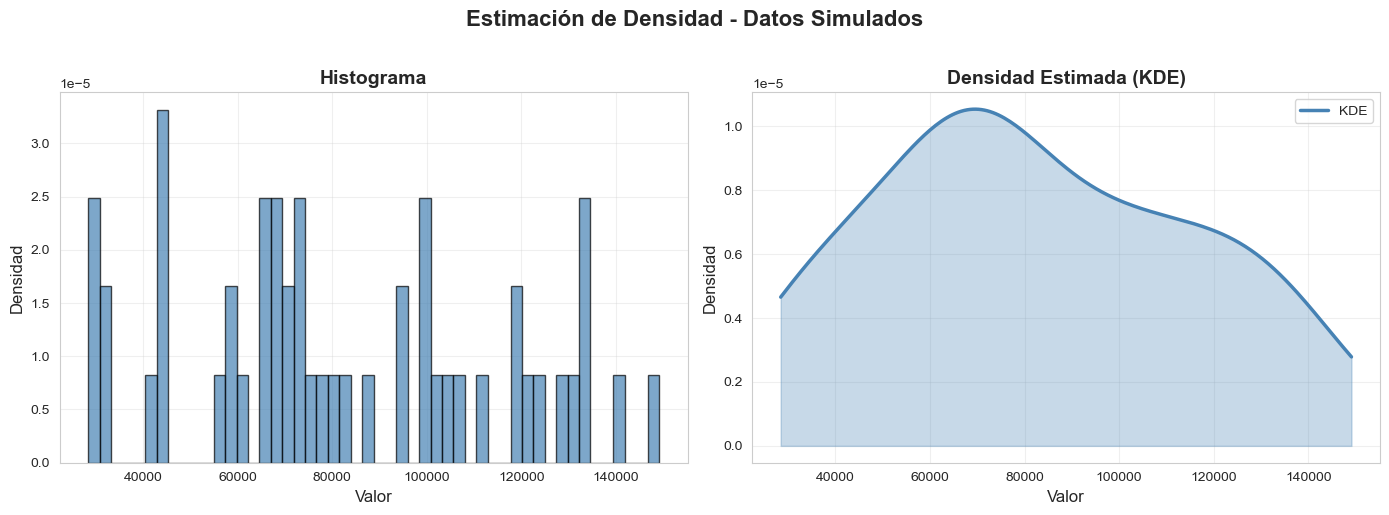

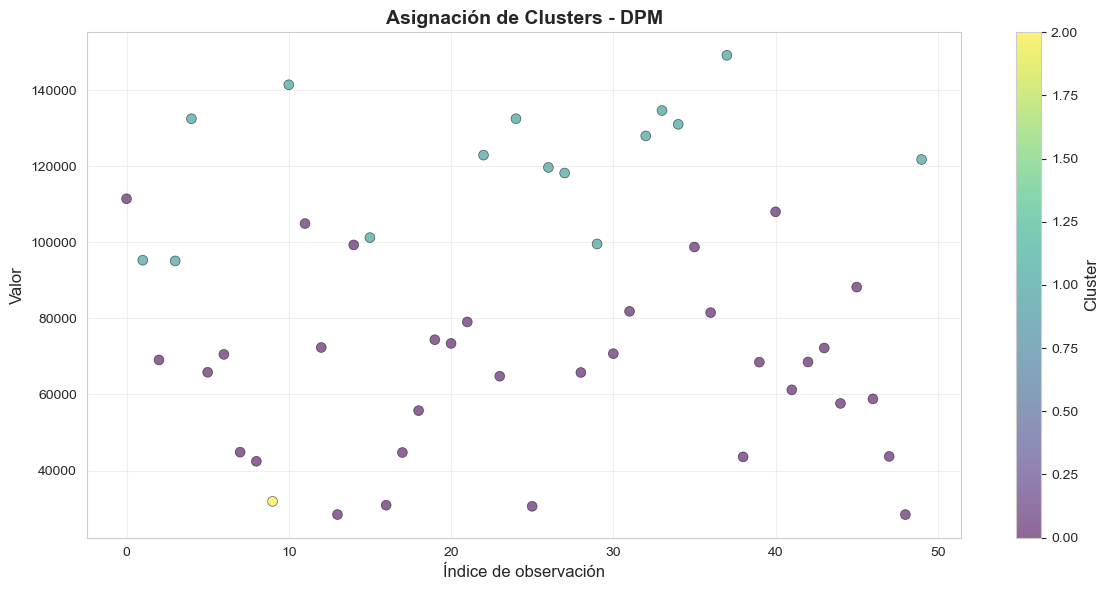

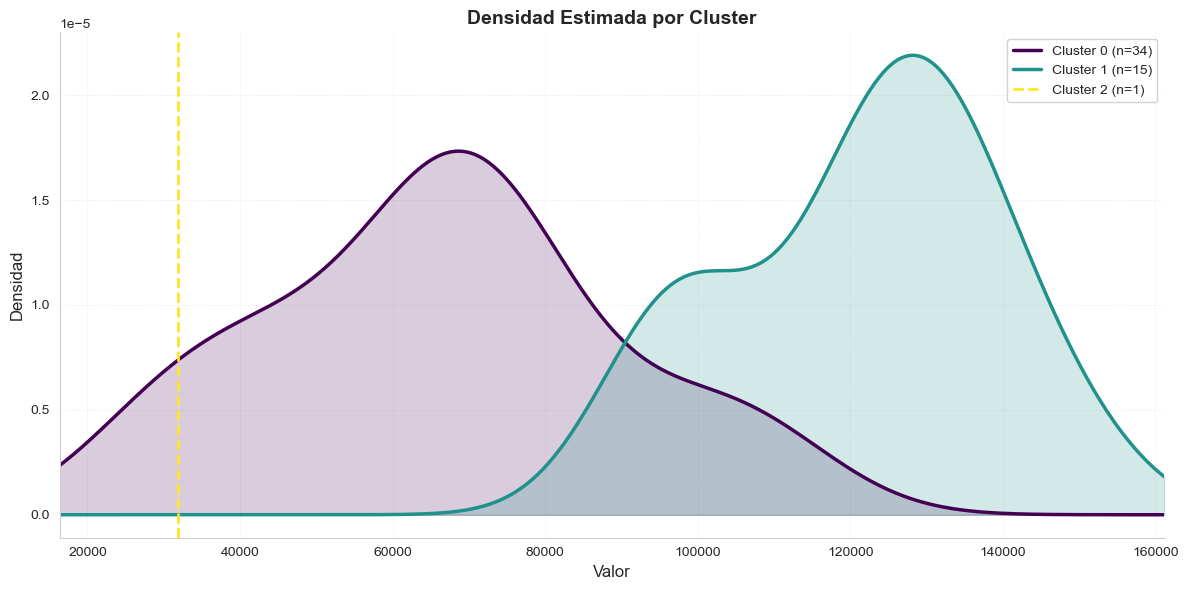

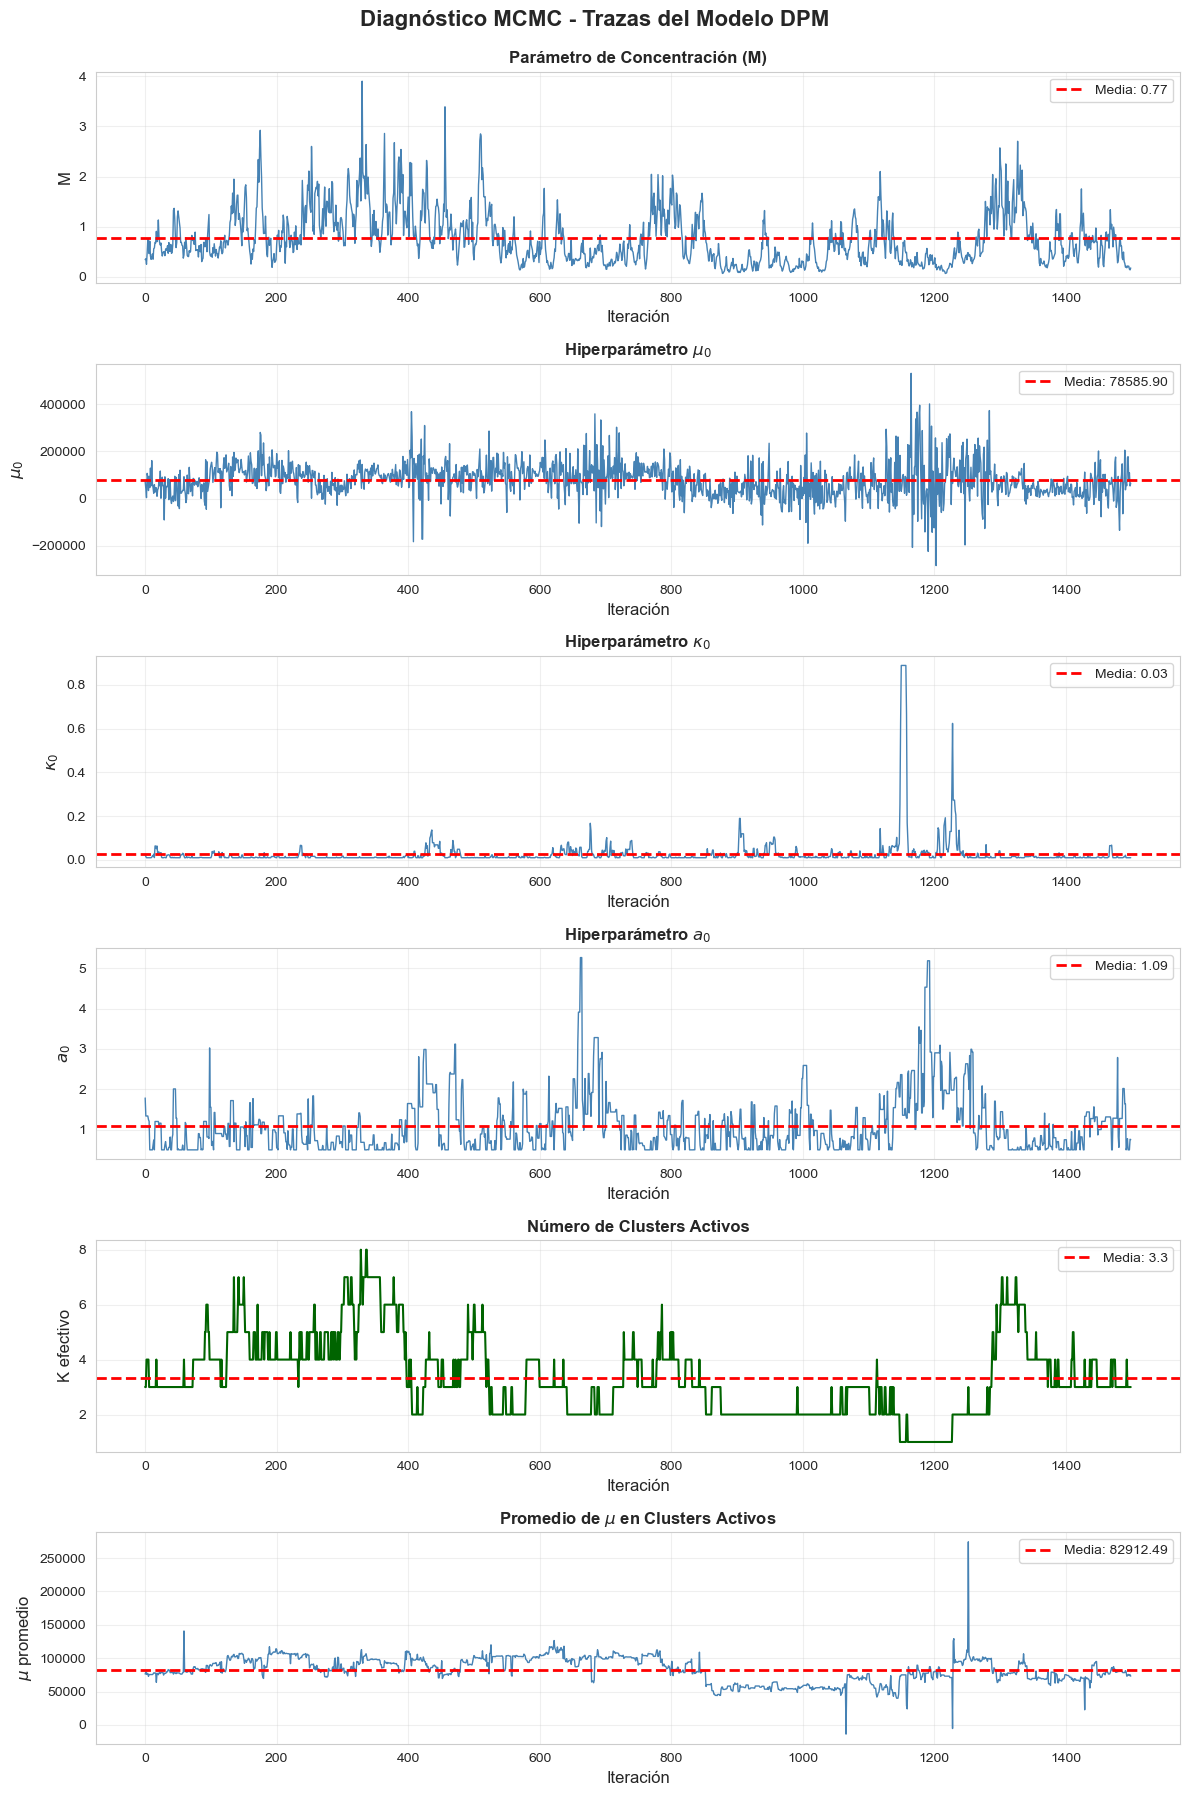

In [11]:
##################################################
# Graficos de diagnostico y analisis
##################################################

# %% 1. Gráfico de Densidad Estimada (Histograma + KDE)
print("\n📊 Generando gráfico de densidad...")
graphics_base_path = get_report_path(config, data_type=SIM_REAL, report_type="graphics")
graphics_path = graphics_base_path / NOMBRE_EJECUCION  # Subcarpeta con nombre de ejecución
graphics_path.mkdir(parents=True, exist_ok=True)

fig1 = plot_density_estimation(
    data=datos['Monthly_Salary'].values,
    bins=50,
    title="Estimación de Densidad - Datos Simulados",
    save_path=graphics_path / "density.png"
)

# %% 2. Gráfico de Asignación de Clusters
print("📊 Generando gráfico de asignación de clusters...")
fig2 = plot_cluster_assignment(
    data=datos['Monthly_Salary'].values,
    clusters=datos['cluster'].values,
    title="Asignación de Clusters - DPM",
    save_path=graphics_path / "clusters_assignment.png"
)

# %% 3. Gráfico de Densidades por Cluster
print("📊 Generando gráfico de densidades por cluster...")
fig3 = plot_cluster_densities(
    data=datos['Monthly_Salary'].values,
    clusters=datos['cluster'].values,
    title="Densidad Estimada por Cluster",
    save_path=graphics_path / "clusters_densities.png"
)

# %% 4. Gráfico de Trazas (Diagnóstico MCMC)
print("📊 Generando gráficos de trazas...")
fig4 = plot_traces(
    trace=trace,
    burn_in=0,  # Ya aplicamos burnin en el modelo
    title="Diagnóstico MCMC - Trazas del Modelo DPM",
    save_path=graphics_path / "traces.png"
)

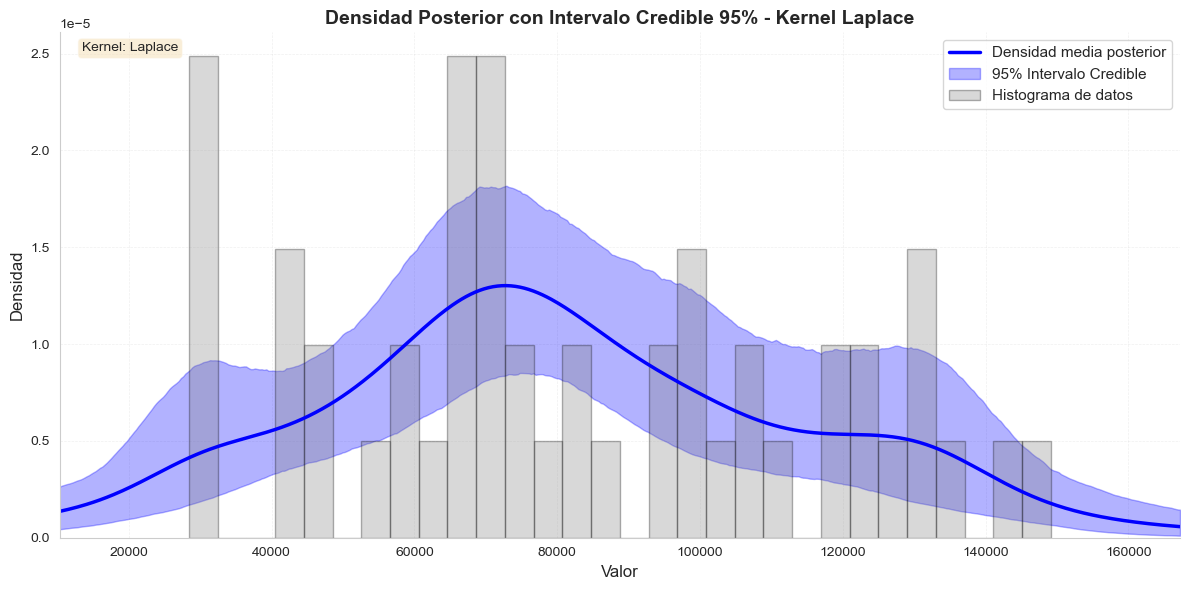

In [12]:
##################################################
# Graficos de intervalo de credibilidad 
##################################################
fig5_laplace = plot_density_credible_interval(
    trace=trace,
    y_data=datos['Monthly_Salary'].values,
    kernel='laplace',
    burn_in=0,  # Ya aplicamos burnin
    n_posterior=2000,
    title="Densidad Posterior con Intervalo Credible 95% - Kernel Laplace",
    save_path=graphics_path / "credible_interval_laplace.png"
)